In [609]:
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

## DataAnalysis

### Reading and saving Datasets

In [31]:
MethTCGA = pd.read_pickle('/home/sbl/Documents/TCGA/Pan Cancer/pancan_methylation.pkl')
MethTCGA = MethTCGA.T

In [66]:
df = pd.read_csv('tcga_Kallisto_tpm.gz', compression='gzip', low_memory=False, sep='\t')
df = df.set_index('sample')
df.to_pickle('TCGA.Kallisto.TPM.pkl')

In [70]:
df = pd.read_csv('tcga_rsem_isoform_tpm.gz', compression='gzip', low_memory=False, sep='\t')
df = df.set_index('sample')
df.to_pickle('TCGA.RSEM.TPM.pkl')

#### Comparing Kallisto vs RSEM to use for downstream prediction

In [2]:
df_Kallisto = pd.read_pickle('TCGA.Kallisto.TPM.pkl')
df_Kallisto = df_Kallisto.set_index('sample')
TCGAtpm = df_Kallisto.copy()

In [4]:
df_rsem = pd.read_pickle('TCGA.RSEM.TPM.pkl')

In [11]:
merged = pd.merge(df_Kallisto[['TCGA-19-1787-01']], df_rsem[['TCGA-19-1787-01']], right_index=True, left_index=True)

In [29]:
stats.pearsonr(merged.T.values[0], merged.T.values[1])

PearsonRResult(statistic=0.8393262416703067, pvalue=0.0)

### Reading Files

In [2]:
MethTCGA = pd.read_pickle('/home/sbl/Documents/TCGA/Pan Cancer/pancan_methylation.pkl')
MethTCGA = MethTCGA.T

TCGAtpm = pd.read_pickle('TCGA.Kallisto.TPM.pkl')
TCGAtpm = TCGAtpm.set_index('sample')

Meth450Annotations = pd.read_table('HM450.hg38.manifest.gencode.v22.tsv.gz', compression='gzip', low_memory=False, sep='\t')

In [ ]:
CommPatients = MethTCGA.columns.intersection(TCGAtpm.columns)
MethTCGA = MethTCGA[CommPatients]
TCGAtpm = TCGAtpm[CommPatients]

TCGAtpm = TCGAtpm.astype('float32')
MethTCGA = MethTCGA.astype('float32')

## Downstream Analysis

In [3]:
# Methylation Annotations
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')

In [139]:
# Meth450Annotations.loc[:, 'transcriptTypes'] = Meth450Annotations['transcriptTypes'].str.split(';')
# Meth450Annotations = Meth450Annotations.explode('transcriptTypes')
Meth450Annotations['transcriptTypes'].value_counts()


In [52]:
# Long Non coding RNA
MethlincRNA = Meth450Annotations[Meth450Annotations['transcriptTypes'] == 'lincRNA']
MethlincRNA.loc[:, 'transcriptIDs'] = MethlincRNA['transcriptIDs'].str.split(';')
MethlincRNA = MethlincRNA.explode('transcriptIDs')
lincRNATranscripts = MethlincRNA['transcriptIDs'].unique().tolist()

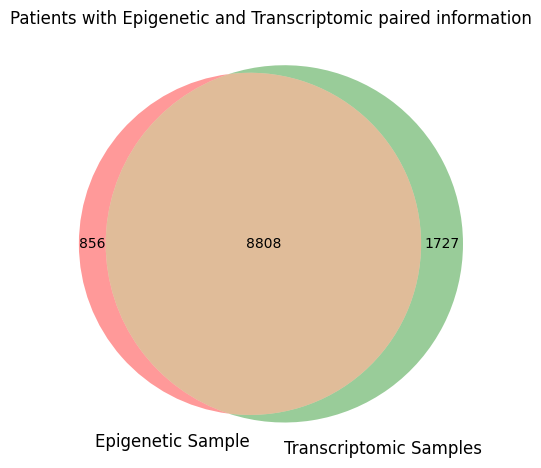

In [77]:
venn2([set(MethTCGA.columns), set(df_Kallisto.columns)],['Epigenetic Sample', 'Transcriptomic Samples'])
plt.title('Patients with Epigenetic and Transcriptomic paired information')
plt.tight_layout()

In [107]:
# sns.histplot(MethTCGA['TCGA-OR-A5J1-01'].values)

### Selecting 1000 Random CPGs for Prediction 
#### Only protein coding 

In [ ]:
# Methylation Annotations
Meth450Annotations = Meth450Annotations.dropna(subset='transcriptIDs')
Meth450Annotations = Meth450Annotations.drop_duplicates(subset='probeID', keep='first')
Meth450Annotations = Meth450Annotations.set_index('probeID')

In [4]:
# Selecting Common CPGS in TCGA and Annotation files
CommonCPGs = list(Meth450Annotations.index.intersection(MethTCGA.index))
Meth450Annotations = Meth450Annotations.loc[CommonCPGs]

In [6]:
# Selecting Protein Coding Genes
ProteinCodCpgsAnnotations = Meth450Annotations[Meth450Annotations['transcriptTypes'] == 'protein_coding']

In [904]:
# Selecting Random Set of CPGs
import random
CPGsRandom = list(random.sample(set(ProteinCodCpgsAnnotations.index), 25000))
RandomCpgsAnnotations = Meth450Annotations.loc[CPGsRandom]
CommTranscripts = TCGAtpm.index[TCGAtpm.index.isin(RandomCpgsAnnotations['transcriptIDs'])]
RandomCpgsAnnotations = RandomCpgsAnnotations[RandomCpgsAnnotations['transcriptIDs'].isin(CommTranscripts)]

In [907]:
CpgsGeneDict = RandomCpgsAnnotations['transcriptIDs'].to_dict()
len(CpgsGeneDict)

17055

In [999]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# Different Scalers for transcripts and methylations
model_br = BayesianRidge()
TPMscaler = StandardScaler()
Methscaler = StandardScaler()

In [35]:
TrainTPM, TestTPM , TrainMeth, TestMeth = train_test_split(TCGAtpm.T, MethTCGA.T, test_size=0.4, random_state=42)

In [ ]:
TrainTPM = (2 ** TrainTPM) - 0.001
TestTPM = (2 ** TestTPM) - 0.001

In [914]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def PredictMethylation(Models, cpgs, Annotations):
    Models = [RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1), ElasticNet(alpha=0.0001, l1_ratio=0.001), 
              ElasticNet( l1_ratio=1),HistGradientBoostingRegressor(random_state=42), 
            BaggingRegressor(estimator= Ridge(alpha=0.001,solver='auto',random_state=42),n_estimators=100,bootstrap=True,max_features=0.7,n_jobs=-1,verbose=False,random_state=123)]
    ResultList = []
    for model in Models:
        for SelectedCpg in cpgs:
            SelectedTranscripts = Annotations.loc[SelectedCpg]['transcriptIDs'].split(';')
            
            model.fit(TPMscaler.fit_transform(TrainTPM[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))

            predictedMeth = model.predict(TPMscaler.transform(TestTPM[SelectedTranscripts].fillna(0)))

            resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[0], 
                        "Euclidean Distance" : distance.euclidean(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'RMSE': root_mean_squared_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "MAE": mean_absolute_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "R2" : r2_score(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'P.Val' : stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[1], 
                        'Model':type(model).__name__, 
                        }
            
            ResultList.append(resultDict)
    return pd.DataFrame(ResultList)
        # pd.DataFrame(ResultList).to_csv('RandomCPGSpearson.csv')

In [751]:
### Result from Random ANalysis of CPGS 
# RFresult = resultDf[resultDf['Model'] == resultDf['Model'].unique()[2]].sort_values(by='PearsonR').dropna()
# mockCpgs = RFresult[RFresult['PearsonR'] >= 0.4]['CPG'].values
# mockCpgs

In [887]:
# Selecting highly variable Transcripts
# TCGAvarTranscripts = TCGAtpm.var(axis=1)
CpgsGeneDict = ProteinCodCpgsAnnotations[ProteinCodCpgsAnnotations['transcriptIDs'].isin(TCGAvarTranscripts.sort_values().tail(500).index)]['transcriptIDs'].to_dict()

In [915]:
Models = [RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1), ElasticNet(alpha=0.0001, l1_ratio=0.001), ElasticNet( l1_ratio=1),HistGradientBoostingRegressor(random_state=42), 
BaggingRegressor(estimator= Ridge(alpha=0.001,solver='auto',random_state=42),n_estimators=100,bootstrap=True,max_features=0.7,n_jobs=-1,verbose=False,random_state=123)]
MethPredicted = PredictMethylation(Models, CpgsGeneDict, ProteinCodCpgsAnnotations)

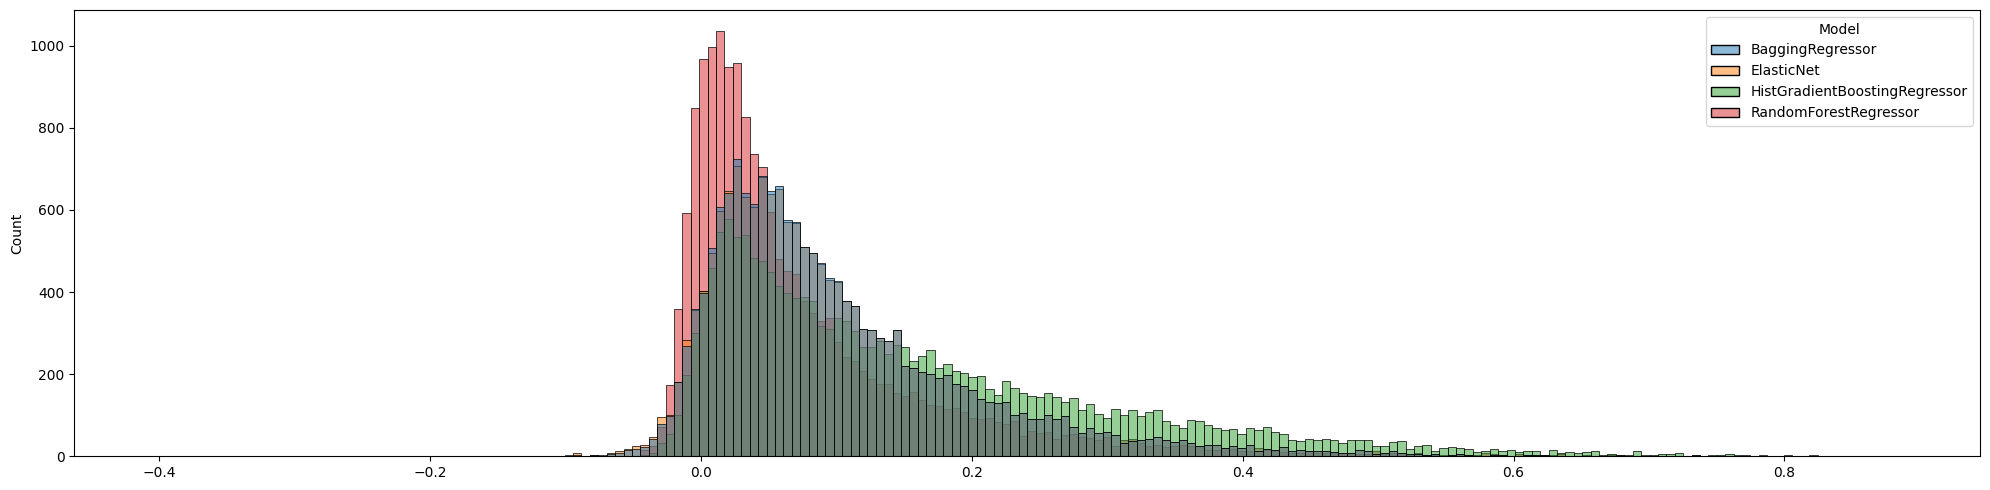

In [988]:
# MethPredicted[MethPredicted.Model.str.contains('Random', case=False)].sort_values(by='PearsonR').dropna().tail(1500)
plt.figure(figsize=(20,5))
sns.histplot(pd.pivot(MethPredicted[['PearsonR','Model']], columns='Model').droplevel(0, axis=1),kde=T)
plt.tight_layout()

In [996]:
MethPredicted[MethPredicted.Model.str.contains('hist', case=False)].sort_values(by='PearsonR').dropna()#.tail(1500)['CPG'][:10]

,CPG,PearsonR,Euclidean Distance,RMSE,MAE,R2,P.Val,Model
60387,cg23649190,-0.045241,3.954181,0.066610,0.021368,-29.955730,0.007229,HistGradientBoostingRegressor
60630,cg06883089,-0.044333,6.479227,0.109145,0.072455,-28.877957,0.008486,HistGradientBoostingRegressor
56457,cg19442915,-0.043589,9.799918,0.165084,0.135070,-27.575832,0.009657,HistGradientBoostingRegressor
64476,cg19543453,-0.038549,0.945473,0.015927,0.011446,-29.360136,0.022112,HistGradientBoostingRegressor
52948,cg09777095,-0.036936,3.522428,0.059337,0.026095,-91.036873,0.028334,HistGradientBoostingRegressor
...,...,...,...,...,...,...,...,...
53004,cg13466284,0.820152,7.408654,0.124802,0.092193,0.539324,0.000000,HistGradientBoostingRegressor
53686,cg22301664,0.825563,1.921354,0.032366,0.011013,0.502508,0.000000,HistGradientBoostingRegressor
61320,cg07037032,0.844891,6.696148,0.112799,0.076030,0.615466,0.000000,HistGradientBoostingRegressor
57634,cg07786675,0.861315,7.818226,0.131701,0.086271,0.663995,0.000000,HistGradientBoostingRegressor


In [932]:
def plotCPG(SelectedCpg, model, axis):
    SelectedTranscripts = ProteinCodCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].split(';')
    QueryTranscript = pd.DataFrame()
    QueryTranscript['Transcript'] = TestTPM.T.loc[SelectedTranscripts].values[0]
    QueryTranscript.index = TestTPM.T.columns
    QueryTranscript.loc[:,"Group"] = QueryTranscript['Transcript'].apply(lambda x: "High" if x > np.median(QueryTranscript.values) else "Low")
    QueryTranscript.loc[:,"Meth"] =  TestMeth[SelectedCpg]
    model.fit(TPMscaler.fit_transform(TrainTPM[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))
    predictedMeth = model.predict(TPMscaler.transform(TestTPM[SelectedTranscripts].fillna(0)))
    QueryTranscript.loc[:,"Pred Meth"] =  predictedMeth
    sns.boxplot(pd.melt(QueryTranscript[['Group','Meth','Pred Meth']], id_vars='Group'), x='variable', y='value', hue='Group', ax=axis)
    plt.tight_layout()
    return QueryTranscript

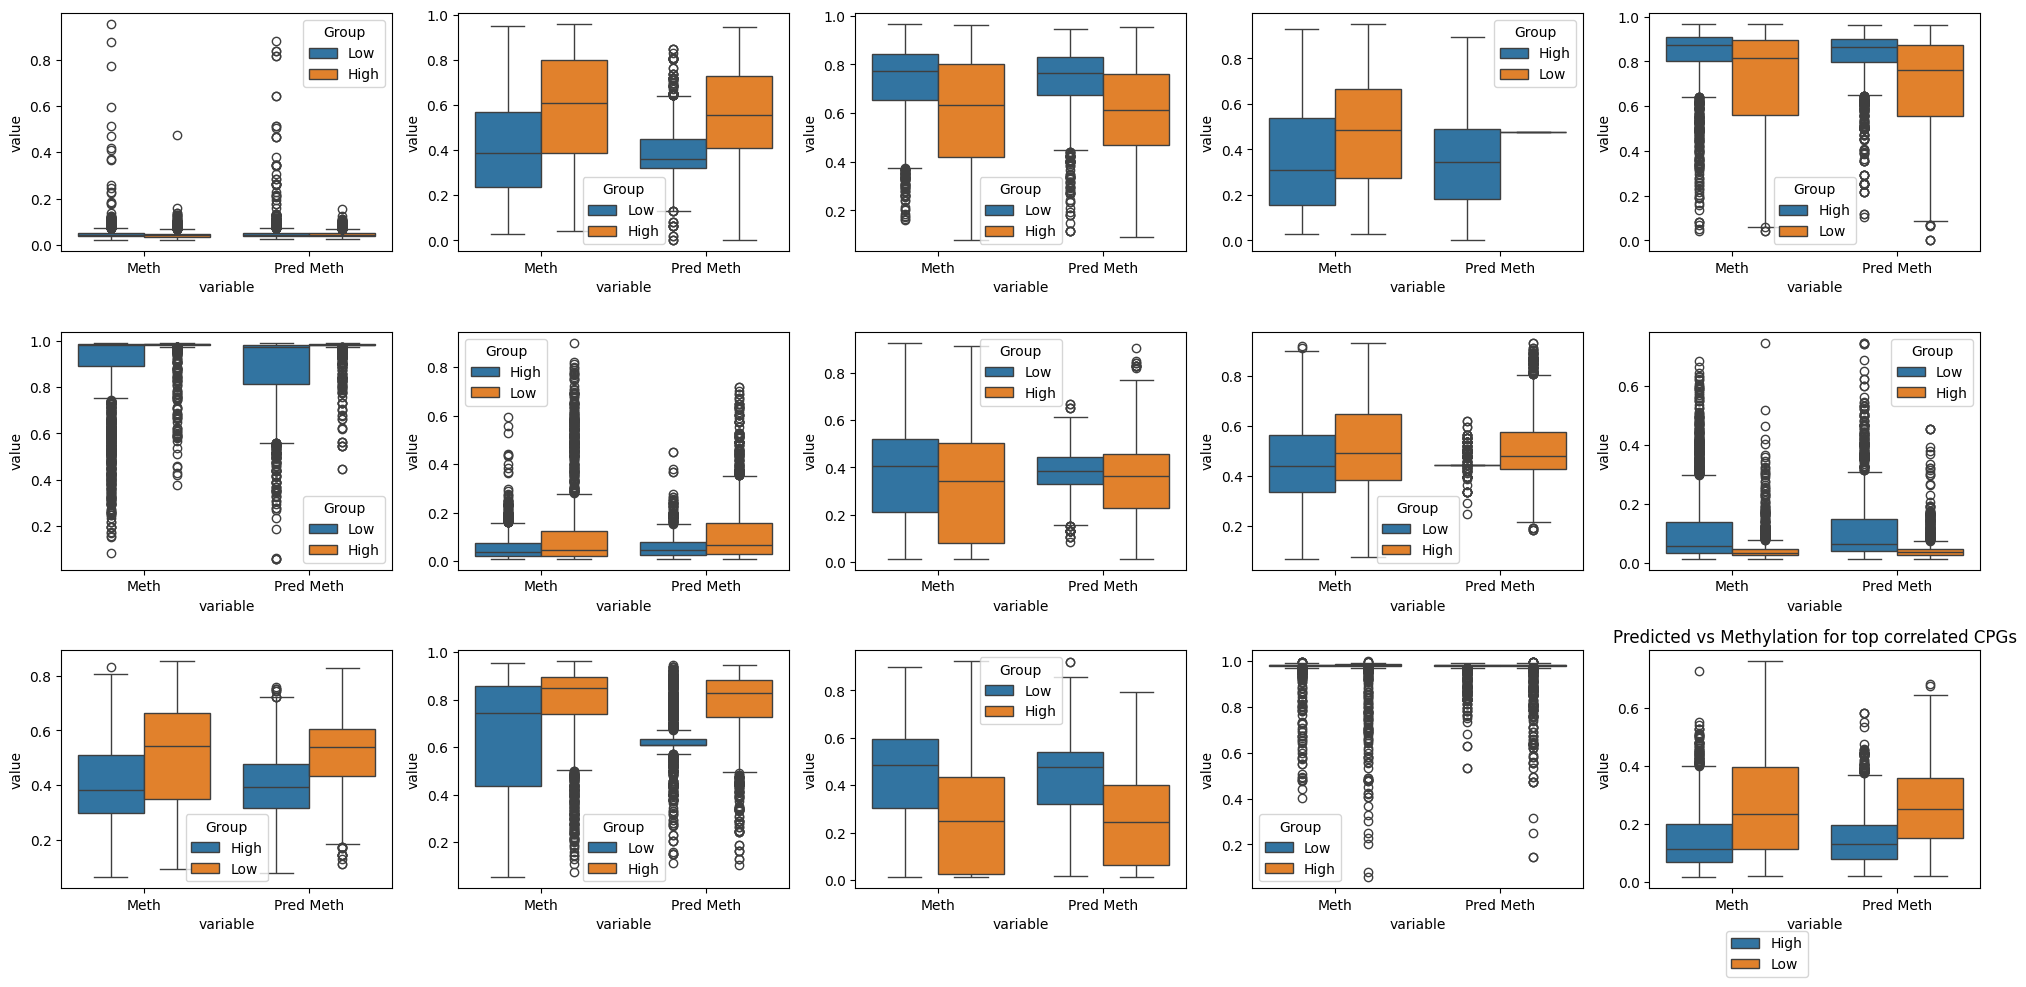

In [973]:
model = RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1)
i = 0
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = list(axes.flatten())
for cpgs in MethPredicted[MethPredicted.Model.str.contains('Random', case=False)].sort_values(by='PearsonR').dropna().tail(1500)['CPG'][:15]:
    ax = plotCPG(cpgs, model, axes[i])
    plt.title(f'{cpgs}')
    i += 1
plt.legend(bbox_to_anchor=(0.5,-0.15))
plt.title('Predicted vs Methylation for top correlated CPGs')
plt.tight_layout()

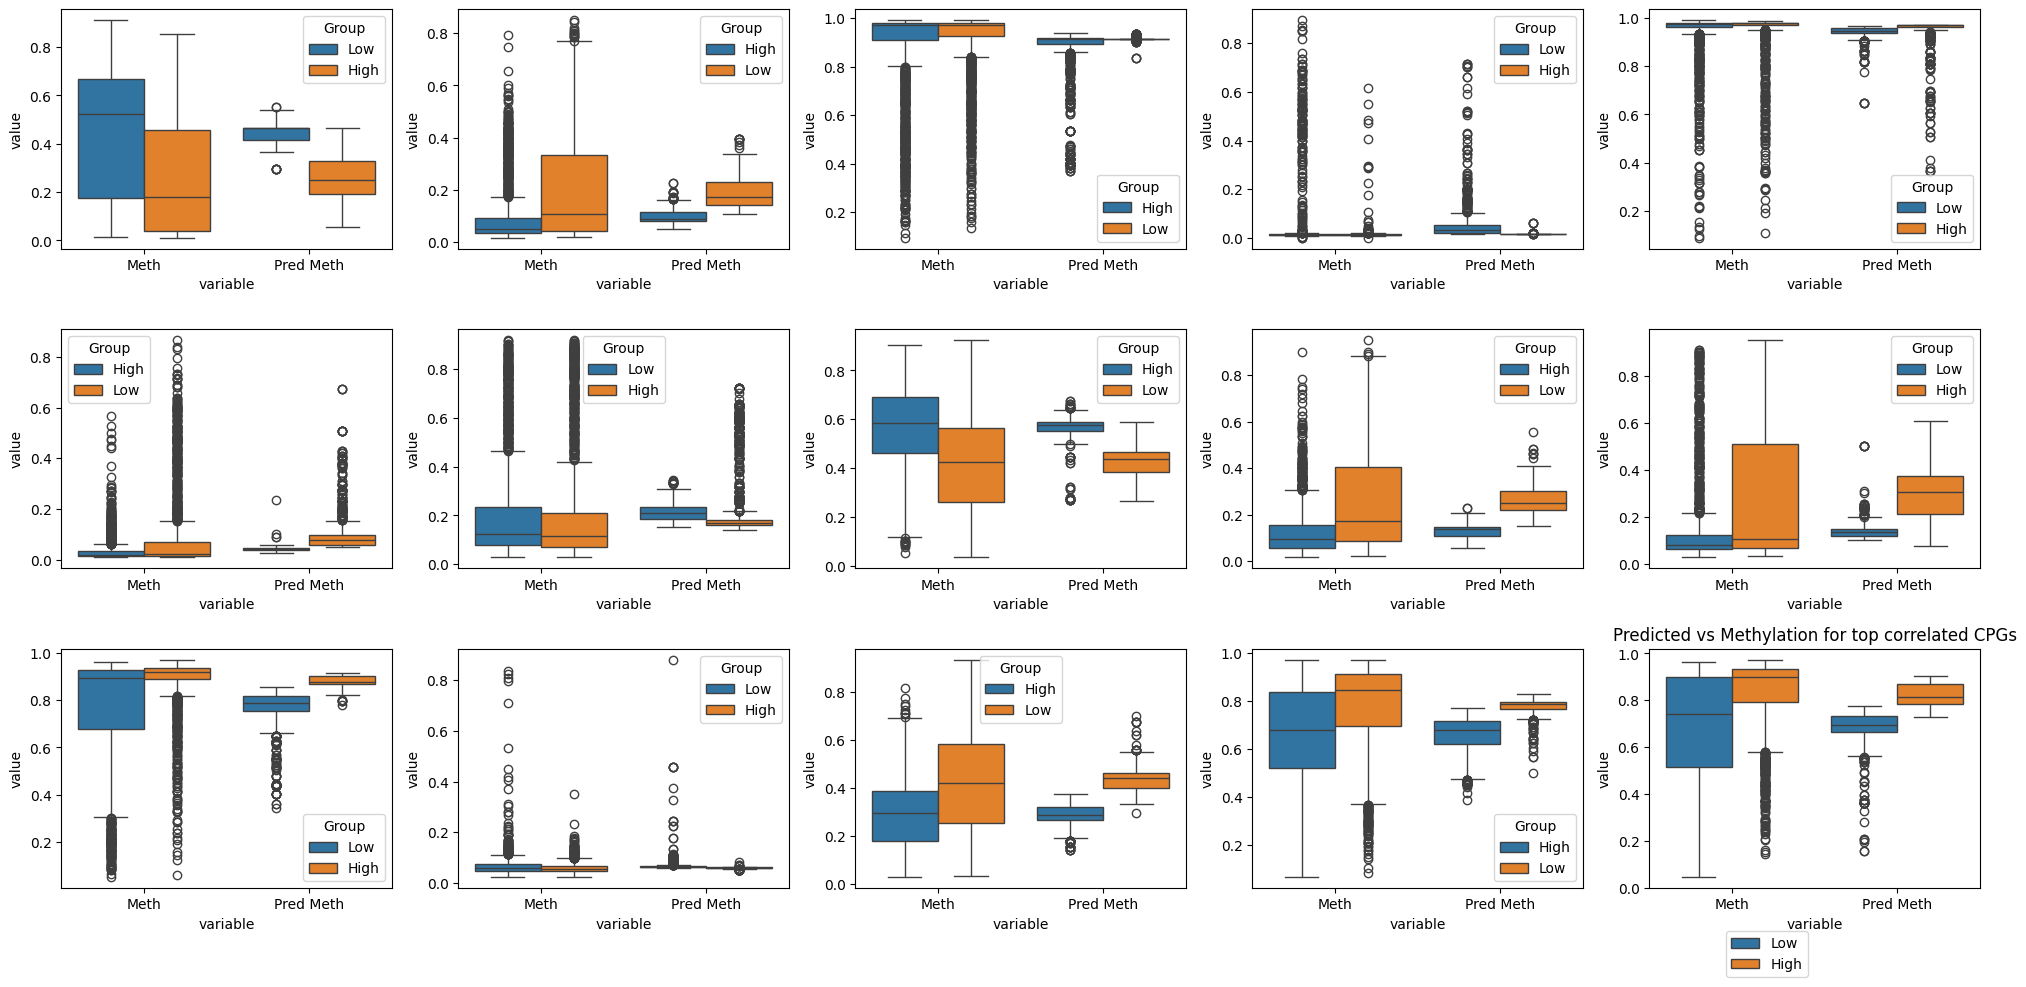

In [1000]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.1)
i = 0
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = list(axes.flatten())
for cpgs in MethPredicted[MethPredicted.Model.str.contains('hist', case=False)].sort_values(by='PearsonR').dropna().tail(1500)['CPG'][:15]:
    ax = plotCPG(cpgs, model, axes[i])
    plt.title(f'{cpgs}')
    i += 1
plt.legend(bbox_to_anchor=(0.5,-0.15))
plt.title('Predicted vs Methylation for top correlated CPGs')
plt.tight_layout()

#### Using Deep Learning

In [972]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [1129]:
class CpGDataset(Dataset):
    def __init__(self, expression_data, methylation_data):
        self.cpG_sites = list(expression_data.keys())
        self.num_samples = len(next(iter(expression_data.values())))
        self.expression_data = expression_data
        self.methylation_data = methylation_data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample_input = {}
        sample_target = {}
        for cpG in self.cpG_sites:
            # Get the expression and methylation data for the sample at index idx
            expr = self.expression_data[cpG][idx].float()
            meth = self.methylation_data[cpG][idx].float()
            sample_input[cpG] = expr
            sample_target[cpG] = meth
        return sample_input, sample_target

def collate_fn(batch):
    batch_inputs = {}
    batch_targets = {}
    for cpG in cpG_to_transcripts.keys():
        batch_inputs[cpG] = torch.stack([sample[0][cpG] for sample in batch])
        batch_targets[cpG] = torch.stack([sample[1][cpG] for sample in batch])
    return batch_inputs, batch_targets

In [1316]:
class CpGNet(nn.Module):
    def __init__(self, cpG_to_transcripts, hidden_size=16):
        super(CpGNet, self).__init__()
        self.cpG_to_transcripts = cpG_to_transcripts
        self.subnets = nn.ModuleDict()

        for cpG, transcript in cpG_to_transcripts.items():
            subnet = nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, 1)
            )
            self.subnets[cpG] = subnet

    def forward(self, x):
        outputs = {}
        for cpG, subnet in self.subnets.items():
            inputs = x[cpG].unsqueeze(-1)  # Shape: [batch_size, 1]
            outputs[cpG] = subnet(inputs).squeeze(-1)  # Shape: [batch_size]
        return outputs

def compute_loss(outputs, targets):
    criterion = nn.MSELoss()
    loss = 0.0
    for cpG in outputs.keys():
        loss += criterion(outputs[cpG], targets[cpG])
    return loss

In [1317]:
# Deeper Network
# class CpGNet(nn.Module):
#     def __init__(self, cpG_to_transcripts, hidden_sizes=[64, 32]):
#         super(CpGNet, self).__init__()
#         self.cpG_to_transcripts = cpG_to_transcripts
#         self.subnets = nn.ModuleDict()

#         for cpG, transcripts in cpG_to_transcripts.items():
#             input_size = len(transcripts)
#             layers = []
#             layers.append(nn.Linear(input_size, hidden_sizes[0]))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(0.3))  # Regularization

#             for i in range(1, len(hidden_sizes)):
#                 layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
#                 layers.append(nn.ReLU())
#                 layers.append(nn.Dropout(0.3))

#             layers.append(nn.Linear(hidden_sizes[-1], 1))
#             subnet = nn.Sequential(*layers)
#             self.subnets[cpG] = subnet

#     def forward(self, x):
#         outputs = {}
#         for cpG, subnet in self.subnets.items():
#             inputs = x[cpG]
#             outputs[cpG] = subnet(inputs).squeeze(-1)
#         return outputs


In [1318]:
cpG_to_transcripts = dict(list(CpgsGeneDict.items())[:3])
# TestCPGs = MethPredicted[MethPredicted.Model.str.contains('hist', case=False)].sort_values(by='PearsonR').dropna().tail(1500)['CPG'][:4].values
# cpG_to_transcripts = {key: CpgsGeneDict[key] for key in TestCPGs}

DLinput = {}
DLtarget = {}
for SelectedCpg in cpG_to_transcripts.keys():
    SelectedTranscripts = CpgsGeneDict[SelectedCpg]
    DLinput[SelectedCpg] = torch.tensor(TrainTPM[SelectedTranscripts].values)
    DLtarget[SelectedCpg] = torch.tensor(TrainMeth[SelectedCpg].values)

DLOutput = {}
DLMeth = {}
for SelectedCpg in cpG_to_transcripts.keys():
    SelectedTranscripts = CpgsGeneDict[SelectedCpg]
    DLOutput[SelectedCpg] = torch.tensor(TestTPM[SelectedTranscripts].values)
    DLMeth[SelectedCpg] = torch.tensor(TestMeth[SelectedCpg].values)

In [1319]:
batch_size = 512
TrainDataset = CpGDataset(DLinput, DLtarget)
TrainLoader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


TestDataset = CpGDataset(DLOutput, DLMeth)
TestLoader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [1321]:
model = CpGNet(cpG_to_transcripts, hidden_size=10)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 10

In [1322]:
Losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in TrainLoader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = compute_loss(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    Losses.append(loss.item())
    avg_loss = total_loss / len(TrainLoader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.9098
Epoch [2/10], Loss: 0.1281
Epoch [3/10], Loss: 0.0968
Epoch [4/10], Loss: 0.0918
Epoch [5/10], Loss: 0.0904
Epoch [6/10], Loss: 0.0900
Epoch [7/10], Loss: 0.0901
Epoch [8/10], Loss: 0.0900
Epoch [9/10], Loss: 0.0900
Epoch [10/10], Loss: 0.0900


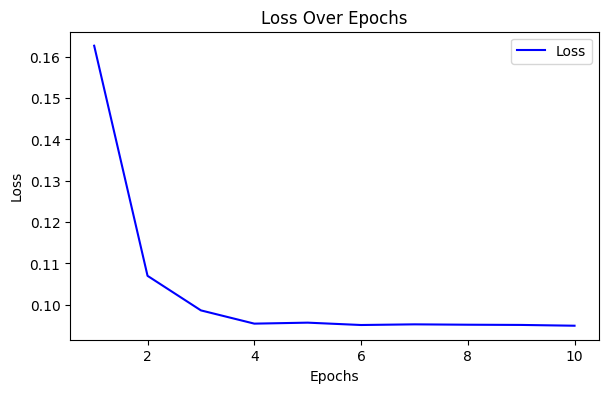

In [1323]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, Losses, 'b', label='Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [1324]:
Outputs = pd.DataFrame()
model.eval()
with torch.no_grad():
    for batch_inputs, batch_targets in TestLoader:
        outputs = model(batch_inputs)
        Outputs = pd.concat([pd.DataFrame(outputs), Outputs ], axis=0)

In [1325]:
ResultList = []
for SelectedCpg in Outputs.columns:
    predictedMeth = Outputs[SelectedCpg]
    resultDict = {'CPG':SelectedCpg, "PearsonR":stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[0], 
                        "Euclidean Distance" : distance.euclidean(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'RMSE': root_mean_squared_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "MAE": mean_absolute_error(predictedMeth,TestMeth[SelectedCpg].fillna(0)),
                        "R2" : r2_score(predictedMeth,TestMeth[SelectedCpg].fillna(0)), 
                        'P.Val' : stats.pearsonr(predictedMeth,TestMeth[SelectedCpg].fillna(0))[1], 
                        'Model':"Deep Learning", 
                        }
    ResultList.append(resultDict)
DLresults = pd.DataFrame(ResultList)

In [1326]:
DLresults

,CPG,PearsonR,Euclidean Distance,RMSE,MAE,R2,P.Val,Model
0,cg08129759,NaN,11.356786,0.191310,0.158989,-4.120735e+13,NaN,Deep Learning
1,cg10278520,-0.002867,9.000223,0.151613,0.121299,-3.235742e+02,0.864881,Deep Learning
2,cg14297772,NaN,9.965283,0.167869,0.127786,0.000000e+00,NaN,Deep Learning


#### Ensemble Model of Machine Learning 

In [1346]:
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

class CpGRegressor:
    def __init__(self, cpG_to_transcripts, base_regressor=None):
        self.cpG_to_transcripts = cpG_to_transcripts
        self.models = {}
        self.base_regressor = base_regressor if base_regressor is not None else RandomForestRegressor()

    def fit(self, expression_data, methylation_data):
        for cpG, transcript in self.cpG_to_transcripts.items():
            X = expression_data[[transcript]].fillna(0).values  # Predictor variables (features)
            y = methylation_data[cpG].fillna(0).values          # Target variable
            model = clone(self.base_regressor)
            model.fit(X, y)
            self.models[cpG] = model

    def predict(self, expression_data):
        predictions = {}
        for cpG, transcript in self.cpG_to_transcripts.items():
            X = expression_data[[transcript]].values
            model = self.models[cpG]
            y_pred = model.predict(X)
            predictions[cpG] = y_pred
        return pd.DataFrame(predictions, index=expression_data.index)

    def evaluate(self, expression_data, methylation_data):
        predictions = self.predict(expression_data)
        mse_scores = {}
        for cpG in self.cpG_to_transcripts.keys():
            mse = stats.pearsonr(methylation_data[cpG].fillna(0),predictions[cpG].fillna(0))[0]
        
            mse_scores[cpG] = mse
        return mse_scores


In [1347]:
CpGRegressor(CpgsGeneDict, base_regressor=RandomForestRegressor(n_estimators=100, random_state=42))

In [ ]:
# Instantiate the model
cpG_regressor = CpGRegressor(CpgsGeneDict, base_regressor=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# expression_train, expression_test, methylation_train, methylation_test = train_test_split(
#     expression_data, methylation_data, test_size=0.2, random_state=42
# )

# Fit the model
cpG_regressor.fit(TrainTPM, TrainMeth)

In [1342]:
cpG_regressor.predict(TestTPM)
mse_scores = cpG_regressor.evaluate(TestTPM, TestMeth)
mse_scores

{'cg08129759': 0.1350625169398547,
 'cg10278520': 0.057402957875012296,
 'cg14297772': 0.20710833847615745}

{'cg08129759': 0.046673332012813304,
 'cg10278520': 0.031724321401424914,
 'cg14297772': 0.03169359678020526}